# A PyTorch Implementation of Algorithms in Optimal and Adaptive Algorithms for Online Boosting

## Implementation Note:
I consider labels of the form {0, 1} and cast to {-1, +1} where needed. This may not be appropriate or necessary, and may be changed in the future.

## Setup

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

transform = transforms.Compose(
   [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# get CIFAR10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# create binary dataset 
trainset.train_labels = np.array(trainset.train_labels)
testset.test_labels = np.array(testset.test_labels)
mask = (trainset.train_labels < 2) # change if desired
trainset.train_data=trainset.train_data[mask]
trainset.train_labels=trainset.train_labels[mask]
mask = (testset.test_labels < 2)
testset.test_data=testset.test_data[mask]
testset.test_labels=testset.test_labels[mask]

# load datasets for experiments: 1 at a time for training; 8 at a time for testing
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


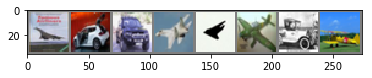

plane   car   car plane plane plane   car plane


In [10]:
import matplotlib.pyplot as plt

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [11]:
# neural net
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
# loss to use
criterion = nn.CrossEntropyLoss()   

# binomial helper function
def binom(a, b):
    return np.math.factorial(a) / (np.math.factorial(a-b) * np.math.factorial(b))

# get output of weak learner i
# o.w. get output of combination of WLs    
def predict_WL(weak_learners, x, i=0):
    with torch.no_grad():
        net, _ = weak_learners[i]
        output = net(x)
        _, predict = torch.max(output.data, 1)
        return predict 

# update weak learner i
def update_WL(weak_learners, x, y, i):
    net, optimizer = weak_learners[i]
    optimizer.zero_grad()
    output = net(x)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    
# get output of combination of WLs (unweighted)
# returns predictions in {-1, +1}
def predict_WL_alg1(weak_learners, x):
    prediction = 0
    N = len(len(weak_learners))
    for i in range(N):
        prediction += predict_WL(weak_learners, x, i)
    return -1 if (prediction < N/2) else 1

# get output of combination of WLs (weighted)
# returns prediction in {-1, +1}
def predict_WL_alg2(weak_learners, x, alpha, i):
    prediction = 0
    for j in range(i):
        prediction += alpha[j] * (2 * predict_WL(weak_learners, x, j) - 1)
    return np.sign(prediction)

In [ ]:
# algorithm 1: online BBM    
def online_BBM(weak_learners):
    N = len(weak_learners)
    s = np.zeros(N+1)
    k = np.zeros(N+1)
    w = np.zeros(N+1)
    
    # T loop
    t = 0
    for i, data in enumerate(trainloader, 0):
        t += 1 
        
        # receive example and label
        x, y = data
        
        # predict y
        y_hat = predict_WL_alg1(weak_learners, x)
        
        # N loop
        for j in range(1,N+1):
            
            # update values
            s[j] = s[j-1] + (2*y -1) * predict_WL(weak_learners, x, j)
            k[j] = np.floor((N-j-s[j-1]+1)/2)
            w[j] = binom(N-j, k[j]) * np.power(1/2 + gamma/2, k[j]) * np.power(1/2 - gamma/2, N-j-k[j])
            
            # pass training example to WL j with some probability
            if np.random.random_sample() < w[j]/np.max(w[j]): # what to take max over
                update_WL(weak_learners, x, j)

In [13]:
# algorithm 2: adaboostOL
def adaboostOL(weak_learners):
    N = len(weak_learners)
    v = np.ones(N+1)
    alpha = np.zeros(N+1)
    y_hat = np.zeros(N+1)
    z = np.zeros(N+1)
    s = np.zeros(N+1)
    
    # T loop
    t = 0
    for i, data in enumerate(trainloader, 0):
        t += 1
        
        # receive example and label
        x, y = data
        
        # predict y wrt each WL
        for j in range(1,N+1):
            y_hat[j] = predict_WL_alg2(weak_learners, x, alpha, j)
            
        # model randomly chooses prediction of some WL
        idx = np.random.choice(N, size=1, p=v/np.sum(v))
        y_hat_final = y_hat[idx]
        
        # N loop
        for j in range(1,N+1):
            
            # set values
            z[j] = (2*y - 1) * predict_WL(weak_learners, x, j)
            s[j] = s[j-1] + alpha[j] * z[j]
            alpha[j] = np.max(-2, np.min(2, alpha[j] + (4 * z[j] / sqrt(t)) / (1 + np.exp(s[j]))))
            
            # pass training example to WL j with some probability
            if np.random.random_sample() < 1 / (1 + exp(s[j-1])):
                update_WL(weak_learners, x, j)
                
            # update v
            indic = -1 if (y_hat_final != y) else 1
            v[j] = v[j] * exp(indic)

In [ ]:
def evaluate_model(net):
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # print subset of images with labels
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))
    
    # print accuracy on test set
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 2000 test images: %d %%' % (100 * correct / total))
    
    # print accuracy on test set per class
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    for i in range(2):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

## Training

In [ ]:
# initialize N weak learners
N = 10
weak_learners = []
import torch.optim as optim
for _ in range(N):
    net = Net()    
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    weak_learners.append((net, optimizer)) 

## Testing

## Citations

Code for CNN: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Online algorithms: http://proceedings.mlr.press/v37/beygelzimer15.pdf